# Skippd Dataset Integration for Cloud Coverage and PV Analysis

## Importing Necessary Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from cloud_detection import cloud_detection
from PIL import Image
from datasets import load_dataset
import cv2
from matplotlib.animation import FuncAnimation

## Loading the Skippd Dataset

In [2]:
# Load Skippd dataset
print("Loading Skippd dataset...")
dataset = load_dataset("skyimagenet/SKIPPD")

# Check dataset structure
print(dataset)

Loading Skippd dataset...
DatasetDict({
    train: Dataset({
        features: ['image', 'time', 'pv'],
        num_rows: 349372
    })
    test: Dataset({
        features: ['image', 'time', 'pv'],
        num_rows: 14003
    })
})


Image format: <class 'PIL.PngImagePlugin.PngImageFile'>
Image size: (64, 64)


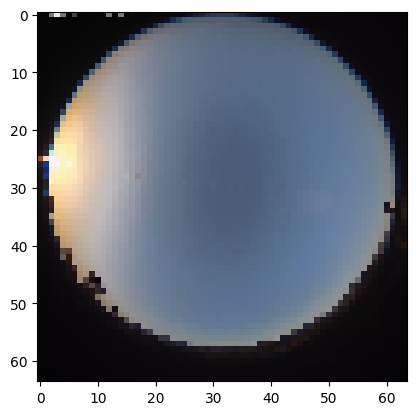

In [3]:
# Load a single sample to inspect the image format
sample = dataset["train"][0]
raw_image = sample["image"]

# Print details
print("Image format:", type(raw_image))
print("Image size:", raw_image.size if hasattr(raw_image, "size") else "N/A")

# Display the raw image
plt.imshow(raw_image)

## Preprocessing Images for Cloud Detection

### Resizing Images to Match Cloud Detection Requirements (64x64)

In [4]:
def preprocess_image(sample):
    # Ensure conversion to a NumPy array
    image = np.array(sample["image"])
    return {"processed_image": image}

# Keep the first 1000 samples from the train dataset to preserve sequence
dataset["train"] = dataset["train"].select(range(min(5000, len(dataset["train"]))))
dataset["test"] = dataset["test"].select(range(min(100, len(dataset["test"]))))
dataset = dataset.map(preprocess_image)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

## Computing Cloud Coverage for Each Image

### Applying the `cloud_detection` Function to the Dataset

In [5]:
def compute_cloud_coverage(sample):
    time = sample["time"]  # Timestamp for the image
    image = np.array(sample["processed_image"])  # Ensure image is a NumPy array
    cloud_cover, _, _ = cloud_detection(time, image)  # Run cloud detection
    return {"cloud_cover": cloud_cover}

# Add cloud coverage column to the dataset
dataset = dataset.map(compute_cloud_coverage)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

c:\Users\santi\OneDrive - De Vinci\A5\Cloud-dection-in-sky-images\codes\cloud_detection.py:38: RuntimeWarning: invalid value encountered in divide
  NRBR_cs = np.divide((match_csl_image[:,:,0].astype(int)-match_csl_image[:,:,2].astype(int)),(match_csl_image[:,:,0].astype(int)+match_csl_image[:,:,2].astype(int)))


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

## Visualizing Cloud Detection for a Single Image

### Function for Visualization

In [6]:
def vis_single_img(time_stamp, image, cloud_cover):
    """
    Visualization of cloud detection results for a single image
    """
    cloud_cover, cloud_mask, sun_mask = cloud_detection(time_stamp, image)

    # Plot original image and cloud detection result
    f, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Original image
    ax[0].imshow(image[:, :, ::-1])
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Cloud detection result
    kernel = np.ones((2, 2), np.uint8)
    bound_cloud = cv2.morphologyEx(cloud_mask, cv2.MORPH_GRADIENT, kernel)
    ax[1].imshow(image[:, :, ::-1])
    ax[1].imshow(sun_mask, alpha=0.15)
    ax[1].imshow(cloud_mask, alpha=0.1)
    ax[1].imshow(bound_cloud, alpha=0.2)
    ax[1].set_title(f"Cloud Cover: {cloud_cover:.2f}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

### Demonstrating Cloud Detection for a Single Image

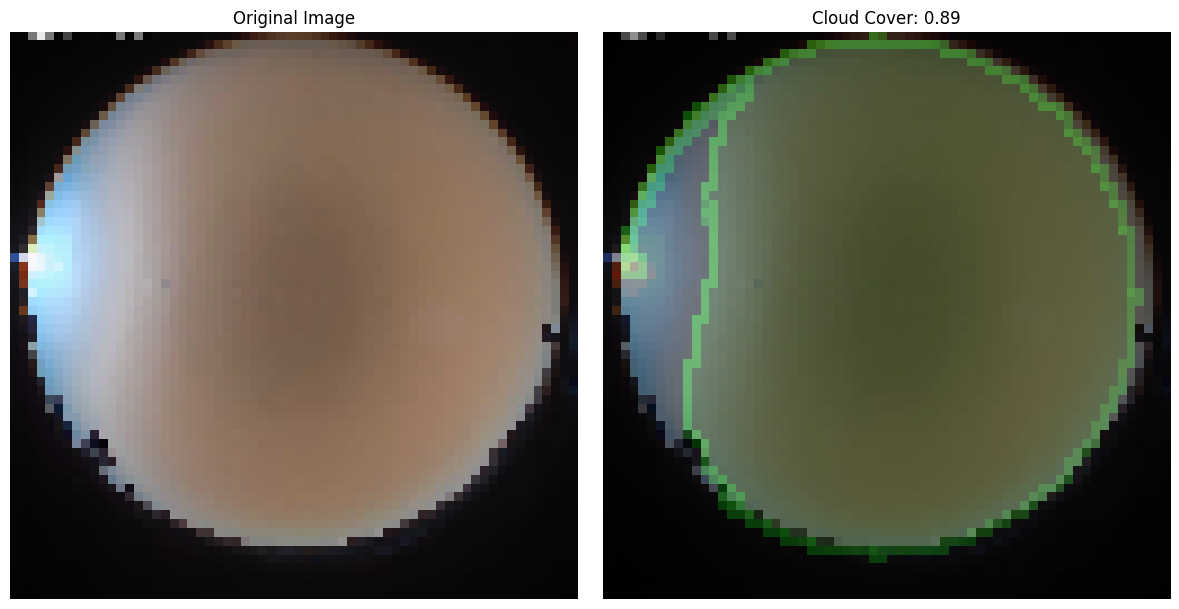

In [7]:
# Visualize one sample from the dataset
sample = dataset["train"][0]
time_stamp = sample["time"]
image = np.array(sample["processed_image"])
cloud_cover = sample["cloud_cover"]
vis_single_img(time_stamp, image, cloud_cover)

## Preparing Data for Regression Analysis

### Adding PV and Cloud Coverage Columns

In [8]:
# Extract relevant columns for regression analysis
train_data = dataset["train"].to_pandas()
train_data = train_data[["time", "pv", "cloud_cover"]]

# Display the first few rows
print(train_data.head())

                       time        pv  cloud_cover
0 2017-03-09 06:47:00-08:00  0.055691     0.894020
1 2017-03-09 06:48:00-08:00  0.088763     0.896291
2 2017-03-09 06:49:00-08:00  0.109171     0.897048
3 2017-03-09 06:50:00-08:00  0.123206     0.899697
4 2017-03-09 06:51:00-08:00  0.159748     0.901968


## Training a Linear Regression Model

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare features and target
X = train_data[["cloud_cover"]].values  # Cloud coverage as the feature
y = train_data["pv"].values  # PV as the target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
print(f"Model R^2 Score: {model.score(X_test, y_test):.2f}")

Model R^2 Score: 0.06


## Creating a Side-by-Side Video with PV and Cloud Coverage

### Visualization of Image Time Series and Cloud Detection Results

In [20]:
def vis_img_ts(time_stamps, images, pvs):
    """
    Visualization of cloud detection results for image time series and PV values
    Generating a video
    """
    images_overlay = np.zeros_like(images, dtype=np.uint8)
    cloud_cover_arr = np.zeros(len(time_stamps))

    for i in range(len(time_stamps)):
        cloud_cover, cloud_mask, sun_mask = cloud_detection(time_stamps[i], images[i])
        cloud_cover_arr[i] = cloud_cover

        # Convert all masks to uint8
        sun_mask = sun_mask.astype(np.uint8)
        cloud_mask = cloud_mask.astype(np.uint8)

        # Morphological gradient for cloud mask to draw edges
        kernel = np.ones((2, 2), np.uint8)
        bound_cloud = cv2.morphologyEx(cloud_mask, cv2.MORPH_GRADIENT, kernel)

        alpha1 = 0.15
        images_overlay[i] = cv2.addWeighted(images[i].astype(np.uint8), 1 - alpha1, sun_mask[:, :, ::-1], alpha1, 0)

        alpha2 = 0.1
        images_overlay[i] = cv2.addWeighted(images_overlay[i], 1 - alpha2, cloud_mask, alpha2, 0)

        alpha3 = 0.2
        images_overlay[i] = cv2.addWeighted(images_overlay[i], 1 - alpha3, bound_cloud, alpha3, 0)

    f, ax = plt.subplots(1, 2)
    img_plot1 = ax[0].imshow(images[0, :, :, ::-1])
    img_plot2 = ax[1].imshow(images_overlay[0, :, :, ::-1])
    pv_text = ax[0].text(0.25, 0.025, '', color='white', transform=ax[0].transAxes)
    cloud_fraction_text = ax[1].text(0.25, 0.025, '', color='white', transform=ax[1].transAxes)

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Original image', fontsize=8)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Cloud detection result', fontsize=8)

    f.tight_layout()

    def update(frame_idx):
        img_plot1.set_data(images[frame_idx, :, :, ::-1])
        img_plot2.set_data(images_overlay[frame_idx, :, :, ::-1])

        pv_text.set_text(f'PV Value={pvs[frame_idx]:.2f}')
        cloud_fraction_text.set_text(f'Cloud fraction={cloud_cover_arr[frame_idx]:.2f}')

        return [img_plot1, img_plot2, pv_text, cloud_fraction_text]

    ani = FuncAnimation(f, update, frames=len(time_stamps), interval=50, blit=True)

    plt.close(f)

    return ani

### Generating and Saving the Video

In [23]:
from moviepy import VideoFileClip

cwd = os.getcwd()
pardir = os.path.dirname(cwd)
output_folder = os.path.join(pardir,"figs") # Specify output folder
os.makedirs(output_folder, exist_ok=True)

def create_video():
    # Convert to a list of dictionaries to iterate properly
    train_samples = list(dataset["train"].select(range(500)))

    # Extract relevant data
    time_stamps = [sample["time"] for sample in train_samples]
    images = np.array([sample["processed_image"] for sample in train_samples])
    pvs = [sample["pv"] for sample in train_samples]

    ani = vis_img_ts(time_stamps, images, pvs)

    # Save the animation as GIF
    gif_path = os.path.join(output_folder, 'cloud_detection_PV.gif')
    ani.save(gif_path, writer='pillow', dpi=300)
    print(f"Animation saved successfully at: {gif_path}")

    # Convert the saved GIF to MP4
    mp4_path = os.path.join(output_folder, 'cloud_detection_PV.mp4')
    clip = VideoFileClip(gif_path)
    clip.write_videofile(mp4_path, codec='libx264')
    print(f"Converted GIF to MP4: {mp4_path}")

create_video()

c:\Users\santi\OneDrive - De Vinci\A5\Cloud-dection-in-sky-images\codes\cloud_detection.py:38: RuntimeWarning: invalid value encountered in divide
  NRBR_cs = np.divide((match_csl_image[:,:,0].astype(int)-match_csl_image[:,:,2].astype(int)),(match_csl_image[:,:,0].astype(int)+match_csl_image[:,:,2].astype(int)))


Animation saved successfully at: c:\Users\santi\OneDrive - De Vinci\A5\Cloud-dection-in-sky-images\figs\cloud_detection_PV.gif
{'video_found': True, 'audio_found': False, 'metadata': {}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1920, 1440], 'bitrate': None, 'fps': 20.0, 'codec_name': 'gif', 'profile': None}], 'input_number': 0}], 'duration': 25.0, 'bitrate': 15547, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'gif', 'video_profile': None, 'video_size': [1920, 1440], 'video_bitrate': None, 'video_fps': 20.0, 'video_duration': 25.0, 'video_n_frames': 500}
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\imageio_ffmpeg\binaries\ffmpeg-win-x86_64-v7.1.exe -i c:\Users\santi\OneDrive - De Vinci\A5\Cloud-dection-in-sky-images\figs\cloud_detection_PV.gif -loglevel error -f image2pipe -vf scale=1920:1440 -sws_flags bicubic -pi

MoviePy - Done !
MoviePy - video ready c:\Users\santi\OneDrive - De Vinci\A5\Cloud-dection-in-sky-images\figs\cloud_detection_PV.mp4
Converted GIF to MP4: c:\Users\santi\OneDrive - De Vinci\A5\Cloud-dection-in-sky-images\figs\cloud_detection_PV.mp4


In [24]:
from IPython.display import Video

Video(os.path.join(output_folder,'cloud_detection_PV.mp4'), embed=True)